# 1. Download data and utils

In [1]:
from IPython.display import clear_output

In [2]:
!pip install emoji
clear_output()

In [3]:
!gdown --id 1kZXyzmfWs2W1F0hOJ0yIIzN_TnF9oqHB # glove.6B.50d.txt
!gdown --id 1KqqaorkmBqi8c__RNA3OG3KoxjjKKepG # model_utils.py
!gdown --id 1ZjrS190X6AO9oIhDusj_SXLXzoEgIX2D # utils.py
!gdown --id 1rP7cr_q-C_lav2uxrIA8kJdHi2wg9EdX # data.csv
clear_output()

# 2. Import libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from utils import read_csv, read_glove_vecs, convert_to_one_hot, label_to_emoji
from model_utils import pretrained_embedding_layer, sentences_to_indices
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sn

# 3. Prepare data

In [5]:
X, Y = read_csv('data.csv')
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.2,shuffle=True,random_state=42)
print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'X shape: {X.shape}')

X train shape: (150,)
X test shape: (38,)
X shape: (188,)


In [6]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

you suck 😞
she is happy 😄
you could not solve it 😞
I like it when people smile 😄
I lost my wallet 😞
her smile is so charming 😄
lets brunch some day 🍴
he had to make a home run ⚾
My grandmother is the love of my life	 ❤️
lets exercise ⚾


In [7]:
MAX_SENTENCE_LEN = len(max(X, key=len).split())
print(f'Max sentence length: {MAX_SENTENCE_LEN}')

Max sentence length: 10


In [8]:
N_CLASSES = len(np.unique(Y))
print(f'Number of classes: {N_CLASSES}')

Number of classes: 5


# 4. Prepare model (using GloVe as the embedding matrix)

In [9]:
# using pretrained GloVe with 6B tokens and 50 dimensional feature vectors
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [10]:
def Emojify(input_shape,word_to_vec_map,word_to_index):
    """
    Function creating the Emojify model's graph.
    
    Arguments:
    - input_shape -- shape of the input, usually (max_len,)
    - word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    - word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    - model -- a model instance in Keras
    """
    
    sentence_indices = Input(shape=input_shape,dtype=np.int32)
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map,word_to_index)
    
    embeddings = embedding_layer(sentence_indices)

    X = Bidirectional(LSTM(units=128,return_sequences=True))(embeddings)
    
    X = Dropout(0.3)(X)
    
    X = Bidirectional(LSTM(units=128))(X)

    X = Dropout(0.3)(X)

    X = Dense(units=N_CLASSES)(X)
    
    X = Activation('softmax')(X)
    
    model = Model(inputs=sentence_indices,outputs=X)
    
    return model

In [11]:
model = Emojify((MAX_SENTENCE_LEN,),word_to_vec_map,word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 50)            20000050  
                                                                 
 bidirectional (Bidirectiona  (None, 10, 256)          183296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
early = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=15)  
checkpoint = ModelCheckpoint('best_model.h5',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)  

In [13]:
X_train_indices = sentences_to_indices(X_train,word_to_index,MAX_SENTENCE_LEN)
Y_train_oh = convert_to_one_hot(Y_train,C=N_CLASSES)
X_test_indices = sentences_to_indices(X_test,word_to_index,MAX_SENTENCE_LEN)
Y_test_oh = convert_to_one_hot(Y_test,C=N_CLASSES)

In [14]:
history = model.fit(X_train_indices,
                    Y_train_oh,
                    validation_data=(X_test_indices,Y_test_oh),
                    epochs=50,
                    batch_size=16,
                    shuffle=True,
                    callbacks=[early,checkpoint])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.5897 - accuracy: 0.3133
Epoch 00001: val_accuracy improved from -inf to 0.28947, saving model to best_model.h5
10/10 [==============================] - 23s 514ms/step - loss: 1.5897 - accuracy: 0.3133 - val_loss: 1.4937 - val_accuracy: 0.2895
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.3990 - accuracy: 0.3667
Epoch 00002: val_accuracy improved from 0.28947 to 0.39474, saving model to best_model.h5
10/10 [==============================] - 1s 106ms/step - loss: 1.3990 - accuracy: 0.3667 - val_loss: 1.2806 - val_accuracy: 0.3947
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.1119 - accuracy: 0.6400
Epoch 00003: val_accuracy improved from 0.39474 to 0.50000, saving model to best_model.h5
10/10 [==============================] - 1s 109ms/step - loss: 1.1119 - accuracy: 0.6400 - val_loss: 1.0660 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - ETA: 

# 5. Plot loss and accuracy

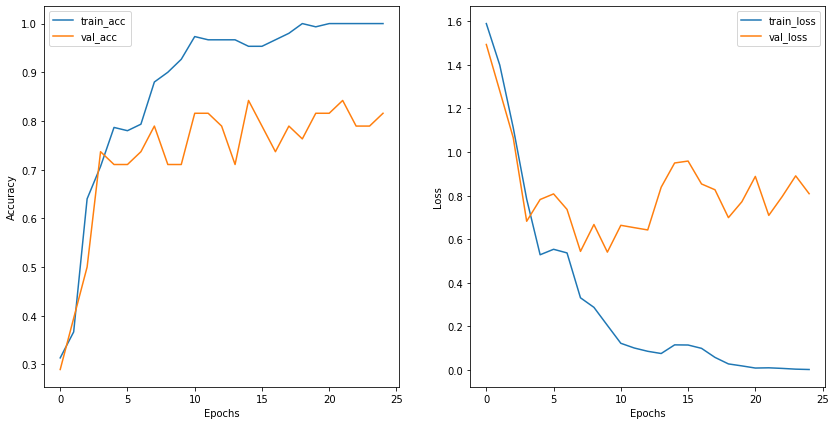

In [15]:
def plot_history(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots(1,2,figsize=(14,7))
    
    ax[0].plot(train_acc,label='train_acc')
    ax[0].plot(val_acc,label='val_acc')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(train_loss,label='train_loss')
    ax[1].plot(val_loss,label='val_loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
plot_history(history)

In [16]:
loss, acc = model.evaluate(X_test_indices,Y_test_oh,batch_size=16)
print()
print(f'Test accuracy = {acc}')

3/3 [==============================] - 0s 18ms/step - loss: 0.8087 - accuracy: 0.8158

Test accuracy = 0.8157894611358643


In [17]:
X_test_indices = sentences_to_indices(X_test,word_to_index,MAX_SENTENCE_LEN)
Y_pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(Y_pred[i])
    if num != Y_test[i]:
        print(f'Expected emoji: {label_to_emoji(Y_test[i])}, prediction: {X_test[i]} {label_to_emoji(num).strip()}')

Expected emoji: 😞, prediction: Stop shouting at me 😄
Expected emoji: 😞, prediction: Stop shouting at me 😄
Expected emoji: 😞, prediction: I think I will end up alone 😄
Expected emoji: 😄, prediction: candy is life  ❤️
Expected emoji: ❤️, prediction: Do you want to give me a hug 😄
Expected emoji: 😄, prediction: will you be my valentine	 😞
Expected emoji: 😄, prediction: valentine day is near	 🍴


In [18]:
matrix = confusion_matrix(Y_test_oh.argmax(axis=1),Y_pred.argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9918 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127860 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9918 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127860 missing from current font.
  font.set_text(s, 0, flags=flags)


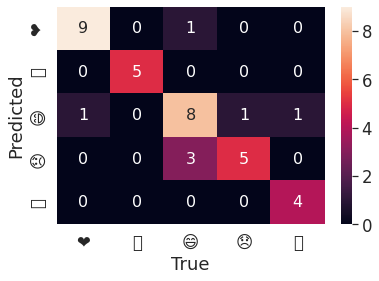

In [19]:
df_cm = pd.DataFrame(matrix, [label_to_emoji(i) for i in range(5)], [label_to_emoji(i) for i in range(5)])
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()